# Compute display LED intensities

In [65]:
import os
import re
import csv
import datetime
import numpy as np
import cv2
from PIL import Image
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [279]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

## Load fireplace video file and extract frames

In [275]:
filename = 'Fireplace 10 hours full HD.mp4'
video_dir = 'videos'
frames_dir = 'video-frames'
image_dir = 'images'
data_dir = 'data'

vidcap = cv2.VideoCapture(os.path.join(video_dir, filename))
vidcap

<VideoCapture 0x1287cfc30>

In [67]:
success, image = vidcap.read()
count = 0
print("Reading frames from video...")
while success and count < 1500:
    filename = f"frame{count:04d}.jpg"
    # save frame as JPEG file
    cv2.imwrite(os.path.join(frames_dir, filename), image)     
    success, image = vidcap.read()
    count += 1
print(f"{count} frame images saved to '{frames_dir}'.")

Reading frames from video...
1500 frame images saved to 'video-frames'.


## Load video frame images

In [68]:
filenames = sorted([name for name in os.listdir(frames_dir)
                    if name.startswith('frame')])
print(f"{len(filenames)} image files found")
filenames[:10]

1500 image files found


['frame0000.jpg',
 'frame0001.jpg',
 'frame0002.jpg',
 'frame0003.jpg',
 'frame0004.jpg',
 'frame0005.jpg',
 'frame0006.jpg',
 'frame0007.jpg',
 'frame0008.jpg',
 'frame0009.jpg']

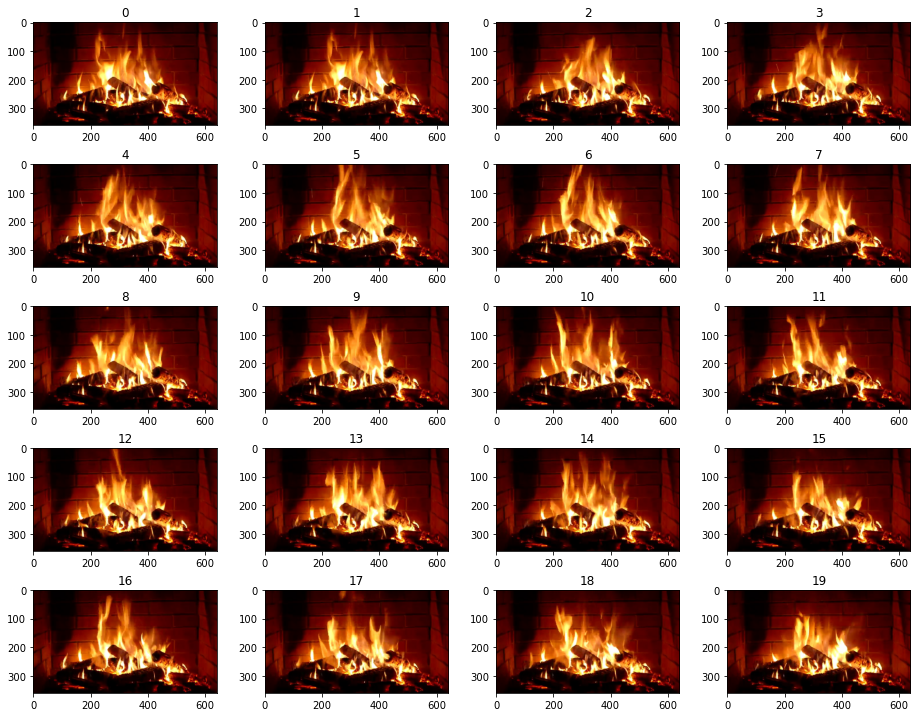

In [69]:
# Display selected images
selection = range(20)
fig, axes = plt.subplots(5, 4, figsize=(13, 10))
for i, img_id in enumerate(selection):
    ax = axes[i // 4, i % 4]
    img = Image.open(os.path.join(frames_dir, filenames[img_id]))
    ax.imshow(img)
    ax.set_title(img_id)
plt.tight_layout()
plt.show()

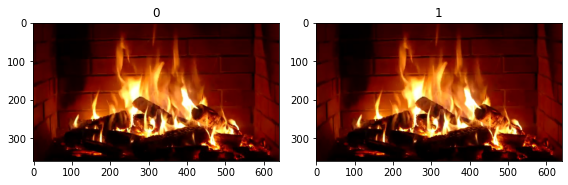

In [70]:
# Compare two frames
selection = [0, 1]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for i, img_id in enumerate(selection):
    ax = axes[i]
    img = Image.open(os.path.join(frames_dir, filenames[img_id]))
    ax.imshow(img)
    ax.set_title(img_id)
plt.tight_layout()
plt.show()

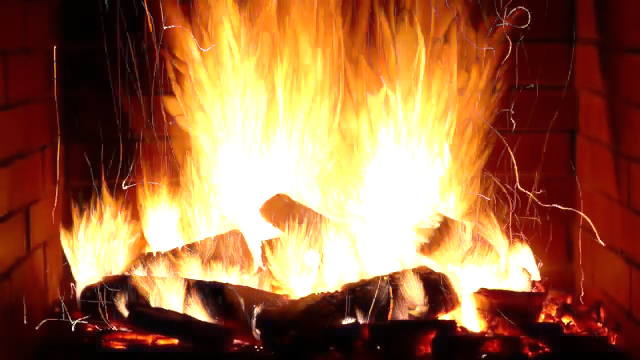

In [71]:
# Combine all frames into one image
img = Image.new('RGB', img.size)
img_data = np.array(img)
for filename in filenames:
    img = Image.open(os.path.join(frames_dir, filename))
    img_data = np.maximum(img_data, np.array(img))
combined_images = Image.fromarray(img_data)
combined_images.save(os.path.join(image_dir, f"combined_{len(filenames)}.jpg"))
combined_images

In [72]:
# Load mask images
images = []
size = None
for i in range(86):
    filename = f"im_{i:03d}.png"
    im = Image.open(os.path.join(image_dir, filename))
    if size is not None:
        assert(im.size == size)
    images.append(im)


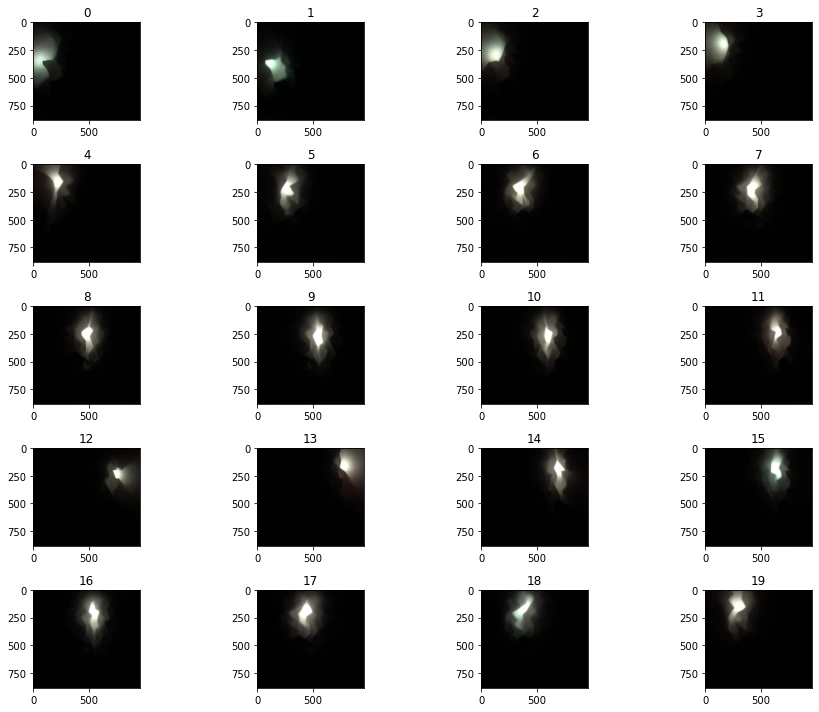

In [73]:
# Display selected mask images
selection = range(20)
fig, axes = plt.subplots(5, 4, figsize=(13, 10))
for i, img_id in enumerate(selection):
    ax = axes[i // 4, i % 4]
    img = images[img_id]
    ax.imshow(img)
    ax.set_title(img_id)
plt.tight_layout()
plt.show()

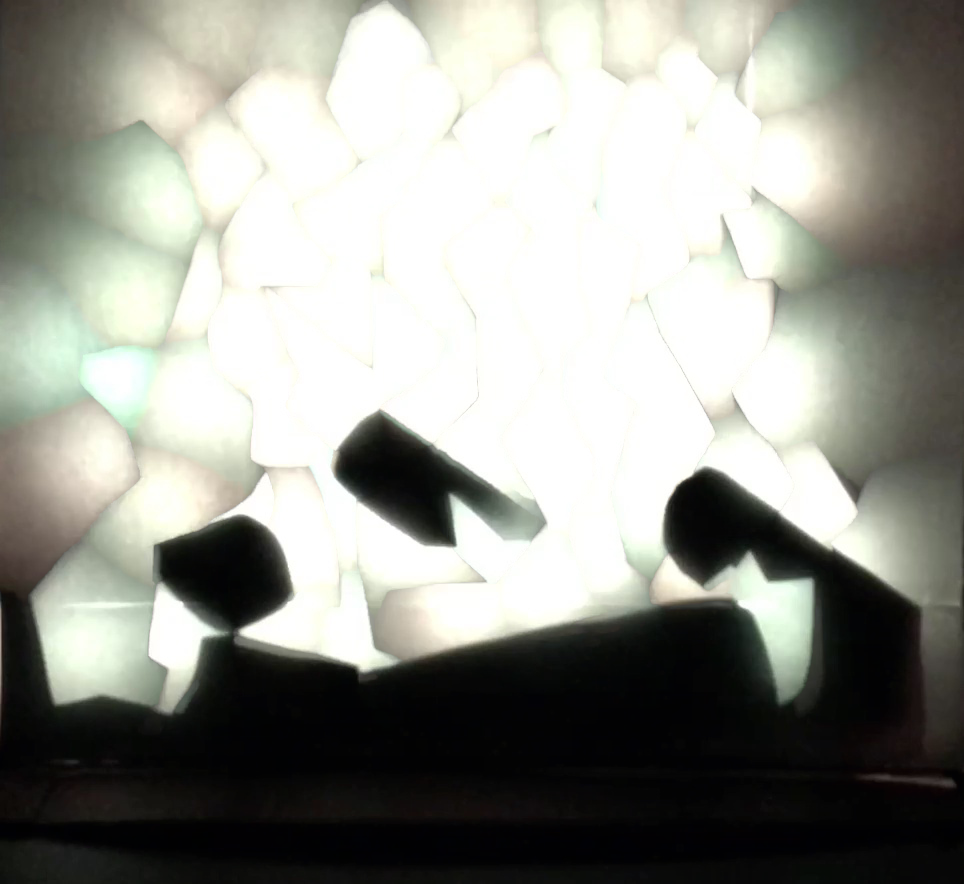

In [74]:
all_masks = Image.open(os.path.join(image_dir, "all_masks_86.png"))
all_masks

## Adjust mask images to match video frames

In [75]:
combined_images.size, all_masks.size

((640, 360), (964, 884))

(430, 347) (430, 347)


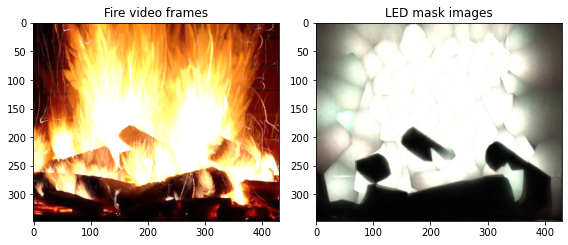

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

img_crop = [110, 13, 540, 360]
mask_crop = [0, 0, 964, 780]

combined_fire_adj = combined_images.crop(img_crop)
all_masks_adj = all_masks.crop(mask_crop)
mask_scale = combined_fire_adj.size[0] / all_masks_adj.size[0]
mask_resize = (np.array(all_masks_adj.size)*mask_scale).astype(int)
all_masks_adj = all_masks_adj.resize(mask_resize)
print(combined_fire_adj.size, all_masks_adj.size)

ax = axes[0]
ax.imshow(combined_fire_adj)
ax.set_title('Fire video frames')

ax = axes[1]
ax.imshow(all_masks_adj)
ax.set_title('LED mask images')

plt.tight_layout()
plt.savefig(os.path.join(image_dir, 'fig_combined_images.png'))
plt.show()

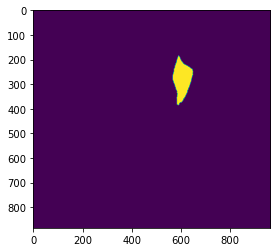

In [77]:
def im_mask(im, thresh=160):
    return (np.array(im) > thresh)[:, :, 0]

plt.imshow(im_mask(images[10]))
plt.show()

## Resize all mask images

In [78]:
# Save images
images = []
image_masks = []
for i in range(86):
    img = Image.open(os.path.join(image_dir, f"im_{i:03d}.png"))
    img_adj = img.crop(mask_crop).resize(mask_resize)
    img_adj.save(os.path.join(image_dir, f"im_{i:03d}_adj.png"))
    images.append(img_adj)
    image_masks.append(im_mask(img_adj))

## View individual masks

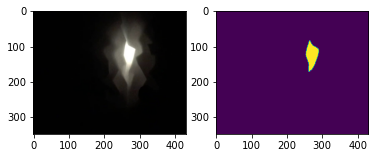

In [79]:
i = 10
img = images[i]
img_mask = Image.fromarray((image_masks[i]*255).astype('uint8'))

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_mask)
plt.show()

## Compute LED intensities to mimic video frame

(430, 347)


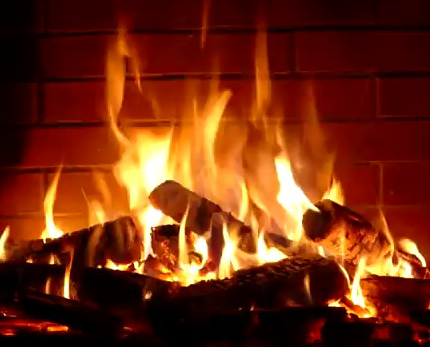

In [80]:
# Select a video frame (Note: 1st two frames are identical for some reason)
filename = filenames[1]
fire_img = Image.open(os.path.join(frames_dir, filename)).crop(img_crop)
print(fire_img.size)
fire_img

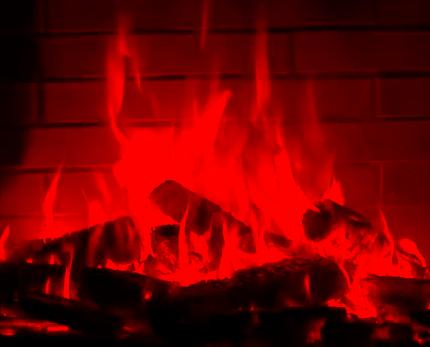

In [81]:
# RGB colours
fire_img_data = np.array(fire_img)
fire_img_data[:, :, 1] = 0
fire_img_data[:, :, 2] = 0
Image.fromarray(fire_img_data)

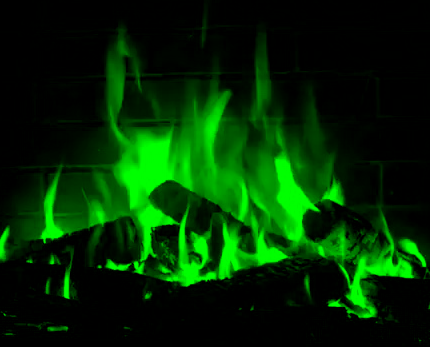

In [82]:
fire_img_data = np.array(fire_img)
fire_img_data[:, :, 0] = 0
fire_img_data[:, :, 2] = 0
Image.fromarray(fire_img_data)

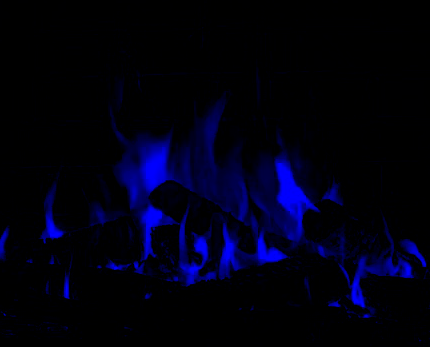

In [83]:
fire_img_data = np.array(fire_img)
fire_img_data[:, :, 0] = 0
fire_img_data[:, :, 1] = 0
Image.fromarray(fire_img_data)

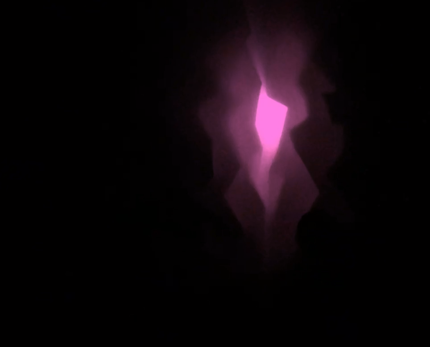

In [84]:
def filter_img_data(img_data, rgb):
    """Linearly adjust image intensities according to the
    rgb adjustment factors.
    """
    return np.clip(img_data.astype('float32') \
                   * np.array(rgb), 0, 255).astype('uint8')

mask_id = 10
mask_img_data = np.array(images[mask_id])

# RGB adjustment factors
rgb = [1, 0.5, 0.9]
                         
img_data_adj = filter_img_data(mask_img_data, rgb)
Image.fromarray(img_data_adj)

In [87]:
# Check masks and video frame images are same shape
fire_img_data.shape, mask_img_data.shape

((347, 430, 3), (347, 430, 3))

## Experiment 1 - compare one mask at a time

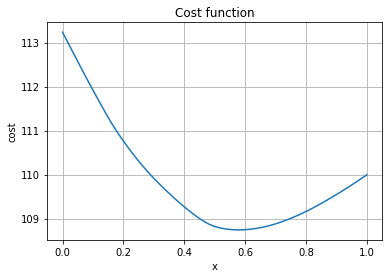

In [97]:
mask_id = 2
c = 0  # colour channel (r, g, b)
mask_img_data_c = np.array(images[mask_id])[:, :, c].astype('float32')

fire_img_data = np.array(fire_img)
fire_img_data_c = fire_img_data[:, :, c].astype('float32')

def cost_function(x):
    mask_img_data_adj = np.clip(mask_img_data_c * x, 0, 255)
    diff = np.abs(fire_img_data_c - mask_img_data_adj)
    return np.mean(diff)

x_values = np.linspace(0, 1, 51)
costs = []
for x in x_values:
    costs.append(cost_function(x))
plt.plot(x_values, costs)
plt.xlabel('x')
plt.ylabel('cost')
plt.title('Cost function')
plt.grid()
plt.show()

In [23]:
x0 = 1
res = minimize(cost_function, x0, bounds=[(0, 1)],
               options={'gtol': 1e-6})
print(res.message)
assert(res.status == 0)
x = res.x[0]
x

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


0.5789473698329792

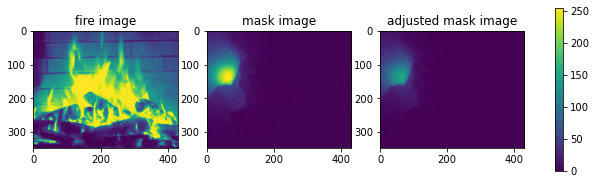

In [24]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

bool_mask = image_masks[mask_id]

img_data = np.zeros(bool_mask.shape)
img_data[bool_mask] = fire_img_data_c[bool_mask]
img1 = Image.fromarray(fire_img_data_c.astype('uint8'))

img2 = Image.fromarray(mask_img_data_c.astype('uint8'))

img3 = Image.fromarray(np.clip(mask_img_data_c * x, 0, 255).astype('uint8'))

fig, axes = plt.subplots(1, 3, figsize=(11, 3))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, 255)
im = cm.ScalarMappable(norm=normalizer)
ax = axes[0]
ax.imshow(img1, vmin=0, vmax=255, cmap=cmap)
ax.set_title('fire image')
ax = axes[1]
ax.imshow(img2, vmin=0, vmax=255, cmap=cmap)
ax.set_title('mask image')
ax = axes[2]
ax.imshow(img3, vmin=0, vmax=255, cmap=cmap)
ax.set_title('adjusted mask image')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig(os.path.join(image_dir, 'fig_image_mask_opt.png'))
plt.show()

## Calculate all led intensities simultaneously

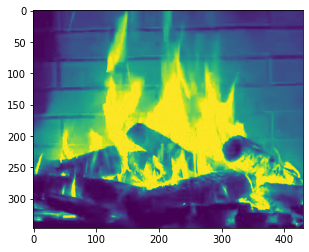

In [103]:
filename = filenames[7]
fire_img = Image.open(os.path.join(frames_dir, filename)).crop(img_crop)
fire_img_data = np.array(fire_img)

c = 0  # colour channel (r, g, b)
fire_img_data_c = fire_img_data[:, :, c]

plt.imshow(fire_img_data_c)
plt.show()

Cost function

$$J(x) = (A - B_1x_1 - B_2x_2 - ... - B_nx_n)^2$$

In [140]:
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])
img_mask_array.shape

(86, 347, 430)

In [148]:
img_mask_array.max()

255.0

In [142]:
img_mask_array.dtype

dtype('float64')

In [186]:
x = np.zeros(86)
x[-1] = 1
x.shape

(86,)

In [187]:
(x.reshape(-1, 1, 1) * img_mask_array).shape

(86, 347, 430)

In [197]:
combined_mask_data = (x.reshape(-1, 1, 1) * img_mask_array).max(axis=0)
combined_mask_data.shape

(347, 430)

In [198]:
combined_mask_data.max()

255.0

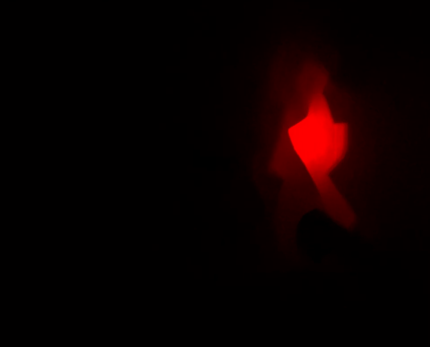

In [201]:
combined_img_data_uint8 = np.stack([
    np.clip(combined_mask_data, 0, 255), 
    np.zeros((347, 430)), 
    np.zeros((347, 430))
], axis=2).astype('uint8')

Image.fromarray(combined_img_data_uint8)

In [202]:
combined_mask_data.shape

(347, 430)

In [206]:
diff = (fire_img_data_c - combined_mask_data) ** 2
diff

17817.20400777428

In [207]:
def cost_function(x):
    combined_mask_data = (x.reshape(-1, 1, 1) * img_mask_array).max(axis=0)
    diff = (fire_img_data_c - combined_mask_data) ** 2
    return np.mean(diff)

x = np.random.rand(86)
cost_function(x)

5917.371624351942

In [239]:
%timeit cost_function(x)

57.2 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [210]:
# Solve using optimizer
x0 = np.random.rand(86)
res = minimize(cost_function, x0, method='Powell', 
               bounds=[(0, 1)]*86, tol=0.1)
print(res.message)
assert(res.status == 0)
x = res.x
x

Optimization terminated successfully.


array([0.06470554, 0.52786405, 0.38196601, 0.3291854 , 0.33083793,
       0.34234966, 0.57050849, 0.55836709, 0.8874353 , 0.67376208,
       0.70820393, 0.70664089, 0.41529935, 0.3480859 , 0.38196601,
       0.52786405, 0.53855738, 0.47213595, 0.47213595, 0.7169832 ,
       0.58207086, 0.23606798, 0.27544719, 0.06470554, 0.38196601,
       0.06470554, 0.23606798, 0.56695038, 0.43880262, 0.06470554,
       0.30218964, 0.20273464, 0.03802909, 0.23606798, 0.28663972,
       0.34195069, 0.42953714, 0.06470554, 0.20273464, 0.23606798,
       0.16940131, 0.03967538, 0.06470554, 0.3379184 , 0.85410197,
       0.70040974, 0.85410197, 0.65136733, 0.94316339, 0.94427191,
       0.55465419, 0.51972095, 0.94427191, 0.27568366, 0.79726536,
       0.81387248, 0.94316339, 0.65136732, 0.57772345, 0.79726536,
       0.85975178, 0.73059869, 0.94427191, 0.67376208, 0.61803399,
       0.82076863, 0.94316339, 0.94427191, 0.94427191, 0.65136732,
       0.72164121, 0.94427191, 0.33934579, 0.94427191, 0.94427

In [225]:
def construct_image_rgb(rgb, img_mask_array):
    rgb = np.clip(rgb, 0, 255)
    img_data = []
    for i in range(3):
        combined_mask_data = (rgb[:, i].reshape(-1, 1, 1) * img_mask_array).max(axis=0)
        img_data.append(combined_mask_data)
    combined_img_data_uint8 = np.stack(img_data, axis=2).astype('uint8')
    return Image.fromarray(combined_img_data_uint8)


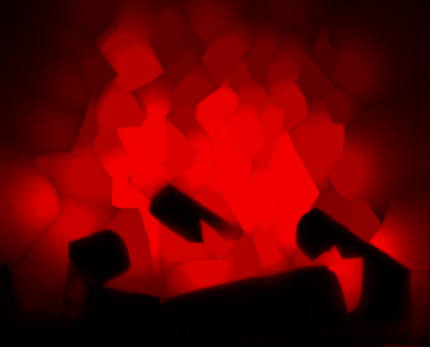

In [226]:
n = len(x)
rgb = np.zeros((n, 3))
rgb[:, 0] = x

construct_image_rgb(rgb, img_mask_array)

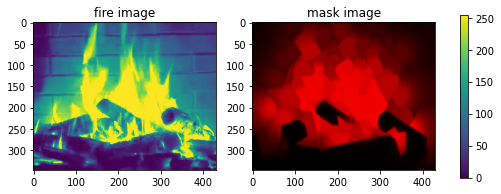

In [215]:
combined_mask_data = (x.reshape(-1, 1, 1) * img_mask_array).max(axis=0)
combined_img_data_uint8 = np.stack([
    np.clip(combined_mask_data, 0, 255), 
    np.zeros((347, 430)), 
    np.zeros((347, 430))
], axis=2).astype('uint8')

img = Image.fromarray(combined_img_data_uint8)

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, 255)
im = cm.ScalarMappable(norm=normalizer)
ax = axes[0]
ax.imshow(fire_img_data_c, vmin=0, vmax=255, cmap=cmap)
ax.set_title('fire image')
ax = axes[1]
ax.imshow(img, vmin=0, vmax=255, cmap=cmap)
ax.set_title('mask image')

fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig(os.path.join(image_dir, 'fig_image_mask_opt_r.png'))
plt.show()


In [2]:
def solve_mask_intensity_c1(target_image, img_mask_array, x0=None,
                            method='Powell', options=None):
    n = img_mask_array.shape[0]
    if x0 is None:
        x0 = 0.5*np.ones(n)

    def cost_function(x):
        combined_mask_data = (
            x.reshape(-1, 1, 1) * img_mask_array
        ).max(axis=0)
        diff = (target_image - combined_mask_data) ** 2
        return np.mean(diff)
    
    res = minimize(cost_function, x0, method=method, 
                   bounds=[(0, 1)]*86, tol=0.1, options=options)
    print(res.message)
    return res

# Example:
#x = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x0,
#                            method='Powell', disp=True)

In [1]:
# Use previous solution as starting point
x0 = [ 0.06470554, 0.52786405, 0.38196601, 0.3291854 , 0.33083793,
       0.34234966, 0.57050849, 0.55836709, 0.8874353 , 0.67376208,
       0.70820393, 0.70664089, 0.41529935, 0.3480859 , 0.38196601,
       0.52786405, 0.53855738, 0.47213595, 0.47213595, 0.7169832 ,
       0.58207086, 0.23606798, 0.27544719, 0.06470554, 0.38196601,
       0.06470554, 0.23606798, 0.56695038, 0.43880262, 0.06470554,
       0.30218964, 0.20273464, 0.03802909, 0.23606798, 0.28663972,
       0.34195069, 0.42953714, 0.06470554, 0.20273464, 0.23606798,
       0.16940131, 0.03967538, 0.06470554, 0.3379184 , 0.85410197,
       0.70040974, 0.85410197, 0.65136733, 0.94316339, 0.94427191,
       0.55465419, 0.51972095, 0.94427191, 0.27568366, 0.79726536,
       0.81387248, 0.94316339, 0.65136732, 0.57772345, 0.79726536,
       0.85975178, 0.73059869, 0.94427191, 0.67376208, 0.61803399,
       0.82076863, 0.94316339, 0.94427191, 0.94427191, 0.65136732,
       0.72164121, 0.94427191, 0.33934579, 0.94427191, 0.94427191,
       0.85410197, 0.94427191, 0.71574452, 0.49398591, 0.69726535,
       0.93037568, 0.61803399, 0.94427191, 0.90983006, 0.85410197,
       0.67376208]

In [235]:
%%time

c = 1
fire_img_data_c = fire_img_data[:, :, c]
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])

options = {'xtol': 0.01, 'disp': True, 'return_all': True}
res = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x,
                            method='Powell', options=options)

print(x)

Optimization terminated successfully.
         Current function value: 2110.265311
         Iterations: 2
         Function evaluations: 1727
Optimization terminated successfully.
[0.04078305 0.00498638 0.00406765 0.00485259 0.04042539 0.31878967
 0.14018775 0.1446347  0.43488465 0.27397152 0.00456767 0.19534112
 0.00615303 0.00430343 0.00462524 0.06225393 0.13248157 0.00518767
 0.07372543 0.08851134 0.12910632 0.00610797 0.00569506 0.00476239
 0.05387077 0.00501292 0.0416757  0.07029374 0.06372334 0.04648026
 0.00640246 0.00447286 0.00574202 0.00559368 0.0062198  0.05032144
 0.00589204 0.06077296 0.00333749 0.00432578 0.06589973 0.0039593
 0.05904567 0.03860615 0.5946145  0.4775294  0.68850758 0.09923453
 0.5347281  0.31200325 0.10406735 0.12865178 0.54021094 0.24134507
 0.44932638 0.40355328 0.72339151 0.24767279 0.18444289 0.40590797
 0.27130638 0.10325468 0.66966363 0.24264579 0.43289682 0.24180512
 0.70562857 0.77664666 0.91680009 0.03901031 0.09053649 0.91316339
 0.24134509 0.789

In [237]:
g = x
g

array([0.04078305, 0.00498638, 0.00406765, 0.00485259, 0.04042539,
       0.31878967, 0.14018775, 0.1446347 , 0.43488465, 0.27397152,
       0.00456767, 0.19534112, 0.00615303, 0.00430343, 0.00462524,
       0.06225393, 0.13248157, 0.00518767, 0.07372543, 0.08851134,
       0.12910632, 0.00610797, 0.00569506, 0.00476239, 0.05387077,
       0.00501292, 0.0416757 , 0.07029374, 0.06372334, 0.04648026,
       0.00640246, 0.00447286, 0.00574202, 0.00559368, 0.0062198 ,
       0.05032144, 0.00589204, 0.06077296, 0.00333749, 0.00432578,
       0.06589973, 0.0039593 , 0.05904567, 0.03860615, 0.5946145 ,
       0.4775294 , 0.68850758, 0.09923453, 0.5347281 , 0.31200325,
       0.10406735, 0.12865178, 0.54021094, 0.24134507, 0.44932638,
       0.40355328, 0.72339151, 0.24767279, 0.18444289, 0.40590797,
       0.27130638, 0.10325468, 0.66966363, 0.24264579, 0.43289682,
       0.24180512, 0.70562857, 0.77664666, 0.91680009, 0.03901031,
       0.09053649, 0.91316339, 0.24134509, 0.78990952, 0.58081

In [238]:
%%time

c = 2
fire_img_data_c = fire_img_data[:, :, c]
img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])

options = {'xtol': 0.01, 'disp': True, 'return_all': True}
res = solve_mask_intensity_c1(fire_img_data_c, img_mask_array, x0=x0,
                            method='Powell', options=options)

print(res.x)
assert(res.status == 0)

b = res.x
b

Optimization terminated successfully.
         Current function value: 1128.483237
         Iterations: 2
         Function evaluations: 1825
Optimization terminated successfully.
[0.00362525 0.00498928 0.00405234 0.0040641  0.00533386 0.08419042
 0.00559201 0.00478199 0.07439218 0.06456071 0.05302315 0.03521154
 0.0053585  0.00442884 0.005924   0.0152344  0.05568855 0.00641589
 0.00541407 0.0045974  0.00485578 0.00826245 0.00520855 0.00369971
 0.00415051 0.00649216 0.00537968 0.00602525 0.00526856 0.00584435
 0.00589067 0.00442884 0.00442884 0.0039315  0.00662824 0.0053186
 0.00577913 0.00600658 0.00492709 0.00359502 0.05693801 0.00584001
 0.03037865 0.05284466 0.33772928 0.26081149 0.61412311 0.05440726
 0.27827963 0.14397078 0.01802332 0.05721053 0.33802591 0.0904244
 0.23125483 0.1572909  0.42150473 0.12504872 0.00424609 0.14289632
 0.07499665 0.033013   0.30106493 0.16001243 0.27681882 0.12195382
 0.28633441 0.1369416  0.55861199 0.00517313 0.00495826 0.06594414
 0.09131578 0.2944

array([0.04078305, 0.00498638, 0.00406765, 0.00485259, 0.04042539,
       0.31878967, 0.14018775, 0.1446347 , 0.43488465, 0.27397152,
       0.00456767, 0.19534112, 0.00615303, 0.00430343, 0.00462524,
       0.06225393, 0.13248157, 0.00518767, 0.07372543, 0.08851134,
       0.12910632, 0.00610797, 0.00569506, 0.00476239, 0.05387077,
       0.00501292, 0.0416757 , 0.07029374, 0.06372334, 0.04648026,
       0.00640246, 0.00447286, 0.00574202, 0.00559368, 0.0062198 ,
       0.05032144, 0.00589204, 0.06077296, 0.00333749, 0.00432578,
       0.06589973, 0.0039593 , 0.05904567, 0.03860615, 0.5946145 ,
       0.4775294 , 0.68850758, 0.09923453, 0.5347281 , 0.31200325,
       0.10406735, 0.12865178, 0.54021094, 0.24134507, 0.44932638,
       0.40355328, 0.72339151, 0.24767279, 0.18444289, 0.40590797,
       0.27130638, 0.10325468, 0.66966363, 0.24264579, 0.43289682,
       0.24180512, 0.70562857, 0.77664666, 0.91680009, 0.03901031,
       0.09053649, 0.91316339, 0.24134509, 0.78990952, 0.58081

In [253]:
# Cost function each iteration
for x in res.allvecs:
    print(cost_function(x))

2658.203175835004
1221.4011572116917
1128.4832373578815


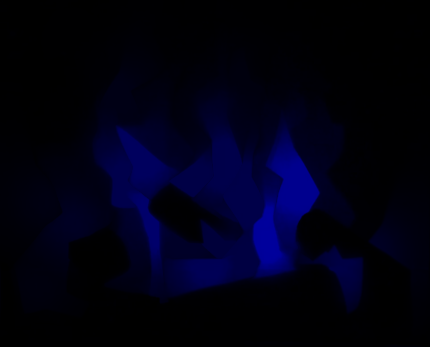

In [241]:
n = len(x)
rgb = np.zeros((n, 3))
rgb[:, 2] = b

construct_image_rgb(rgb, img_mask_array)

## Show RGB LED intensities

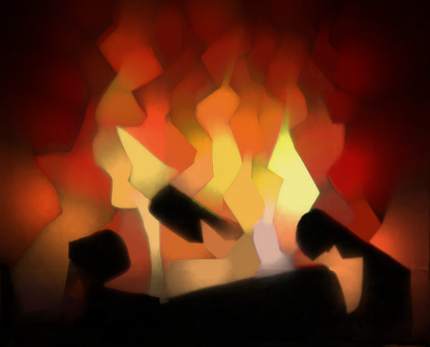

In [242]:
rgb = np.vstack([r, g, b]).T
img = construct_image_rgb(rgb, img_mask_array)
img.save(os.path.join(image_dir, 'reconstructed_image.png'))
img

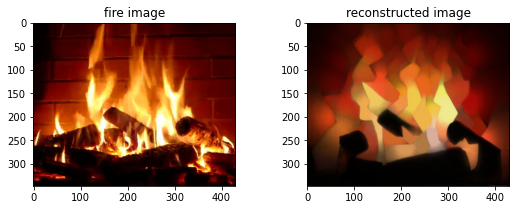

In [246]:
img = construct_image_rgb(rgb, img_mask_array)

fig, axes = plt.subplots(1, 2, figsize=(9, 3))

ax = axes[0]
ax.imshow(fire_img_data)
ax.set_title('fire image')
ax = axes[1]
ax.imshow(img)
ax.set_title('reconstructed image')

plt.savefig(os.path.join(image_dir, 'fig_image_mask_opt.png'))
plt.show()

## Automated calculation of sequence of frames

<font color='red'>Warning: This takes a long time!

In [268]:
# Combine process to compute RGB intensities for whole image

def solve_mask_intensity_rgb(target_image, img_mask_array, rgb0=None,
                             method='Powell', options=None):
    if options is None:
        options = {'xtol': 0.01, 'disp': True, 'return_all': True}

    rgb = []
    results = []
    for c in range(3):
        print(f"\nStarting minimization for '{['r', 'g', 'b'][c]}' channel...")
        target_image_c = target_image[:, :, c]
        img_mask_array = np.stack([np.array(img)[:, :, c].astype('float') for img in images])
        x0 = rgb0[c]
        res = solve_mask_intensity_c1(target_image_c, img_mask_array, x0=x0,
                                      method=method, options=options)
        print(res.message)
        print(res.x)
        assert(res.status == 0)
        rgb.append(res.x)
        results.append(res)
    
    return rgb, results



In [323]:
def save_rgb_seq_data(seq_no, rgb, label='seq_data'):
    dt_string = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
    filename = f'{label}_ids.csv'
    with open(os.path.join(data_dir, filename), 'a') as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerow([dt_string, seq_no])
    for c in range(3):
        filename = f'{label}_rgb_{c}.csv'
        with open(os.path.join(data_dir, filename), 'a') as f:
            data = rgb[c].reshape(1, -1)
            np.savetxt(f, data, '%.3f', ',')

In [329]:
# Initial values for optimizer
rgb0 = [
    np.array([0.247, 0.536, 0.389, 0.322, 0.322, 0.241, 0.818, 0.389, 0.764,
        0.633, 0.599, 0.69 , 0.471, 0.359, 0.47 , 0.243, 0.476, 0.712,
        0.243, 0.482, 0.241, 0.225, 0.246, 0.297, 0.857, 0.644, 0.546,
        0.553, 0.364, 0.329, 0.306, 0.196, 0.006, 0.182, 0.239, 0.241,
        0.455, 0.372, 0.208, 0.229, 0.159, 0.239, 0.181, 0.347, 0.841,
        0.758, 0.87 , 0.695, 0.995, 0.995, 0.599, 0.552, 0.995, 0.243,
        0.885, 0.845, 0.965, 0.638, 0.431, 0.851, 0.877, 0.731, 0.86 ,
        0.88 , 0.67 , 0.581, 0.954, 0.994, 0.984, 0.674, 0.656, 0.938,
        0.959, 0.995, 0.995, 0.829, 0.64 , 0.243, 0.371, 0.544, 0.9  ,
        0.746, 0.995, 0.649, 0.822, 0.637]),
     np.array([0.006, 0.061, 0.004, 0.015, 0.017, 0.089, 0.414, 0.27 , 0.147,
        0.1  , 0.164, 0.258, 0.004, 0.005, 0.062, 0.068, 0.086, 0.27 ,
        0.145, 0.054, 0.005, 0.004, 0.003, 0.029, 0.341, 0.152, 0.111,
        0.049, 0.035, 0.035, 0.005, 0.004, 0.005, 0.006, 0.004, 0.038,
        0.006, 0.006, 0.006, 0.006, 0.085, 0.075, 0.006, 0.159, 0.603,
        0.547, 0.739, 0.005, 0.64 , 0.393, 0.155, 0.119, 0.776, 0.631,
        0.49 , 0.471, 0.723, 0.223, 0.057, 0.46 , 0.304, 0.105, 0.306,
        0.376, 0.395, 0.338, 0.242, 0.767, 0.888, 0.004, 0.1  , 0.241,
        0.604, 0.599, 0.629, 0.382, 0.518, 0.097, 0.006, 0.088, 0.525,
        0.273, 0.539, 0.127, 0.32 , 0.174]),
     np.array([0.007, 0.005, 0.004, 0.005, 0.005, 0.004, 0.122, 0.028, 0.044,
        0.039, 0.055, 0.006, 0.005, 0.004, 0.005, 0.028, 0.026, 0.005,
        0.038, 0.004, 0.005, 0.004, 0.006, 0.003, 0.057, 0.005, 0.004,
        0.004, 0.006, 0.003, 0.006, 0.004, 0.005, 0.005, 0.004, 0.004,
        0.005, 0.004, 0.005, 0.004, 0.037, 0.044, 0.039, 0.078, 0.346,
        0.293, 0.576, 0.006, 0.402, 0.166, 0.005, 0.045, 0.389, 0.255,
        0.236, 0.205, 0.389, 0.039, 0.031, 0.155, 0.091, 0.005, 0.105,
        0.068, 0.233, 0.074, 0.006, 0.099, 0.446, 0.005, 0.006, 0.004,
        0.004, 0.189, 0.117, 0.039, 0.152, 0.005, 0.006, 0.028, 0.15 ,
        0.047, 0.11 , 0.006, 0.005, 0.006])
]

In [325]:
%%time

results_record = []

for seq_no in range(6, 11):
    filename = filenames[seq_no]
    
    print(f"\nStarting image {seq_no} from file '{filename}'")
    fire_img = Image.open(os.path.join(frames_dir, filename)).crop(img_crop)
    fire_img_data = np.array(fire_img)

    rgb, results = solve_mask_intensity_rgb(fire_img_data, 
                                            img_mask_array,
                                            rgb0=rgb)
    results_record.append((rgb, results))
    
    save_rgb_seq_data(seq_no, rgb)
    


Starting image 2 from file 'frame0002.jpg'

Starting minimization for 'r' channel...
Optimization terminated successfully.
         Current function value: 2952.208678
         Iterations: 2
         Function evaluations: 1492
Optimization terminated successfully.
Optimization terminated successfully.
[0.24702424 0.52786405 0.38591789 0.31074332 0.2855521  0.24130118
 0.43636805 0.73223851 0.83446716 0.24264579 0.89529897 0.61389597
 0.37809041 0.3550376  0.36914526 0.24084439 0.50855104 0.54437397
 0.4298544  0.30760058 0.22367179 0.22940131 0.23606798 0.2471767
 0.2991456  0.24456824 0.21993198 0.62491877 0.34172138 0.26785667
 0.29583956 0.19250301 0.11843108 0.21674186 0.23273464 0.24133626
 0.28426826 0.21778361 0.21112422 0.22765966 0.15329351 0.20143933
 0.17605867 0.35524918 0.90145697 0.78074997 0.88702371 0.67360059
 0.99520271 0.99520271 0.61063057 0.65981214 0.99520271 0.24264579
 0.7805355  0.82586772 0.91251045 0.6582687  0.58354585 0.8043068
 0.88206528 0.73084783 0.846

Optimization terminated successfully.
         Current function value: 2217.040275
         Iterations: 3
         Function evaluations: 2596
Optimization terminated successfully.
Optimization terminated successfully.
[0.00446406 0.05126568 0.00428678 0.00658676 0.00666197 0.07487422
 0.57446303 0.27871116 0.21634029 0.09453373 0.13915805 0.00632714
 0.00401565 0.00545452 0.00429816 0.03594545 0.00642955 0.14974229
 0.14816986 0.05224197 0.0060868  0.0049969  0.00345655 0.02822444
 0.00616764 0.03441327 0.08267    0.00489661 0.00380169 0.00648034
 0.00488966 0.00442884 0.0044564  0.00552797 0.00611893 0.03005912
 0.04306857 0.00490454 0.00601744 0.00535316 0.07563816 0.00578514
 0.0715149  0.15305214 0.61398278 0.53037029 0.72875382 0.12358408
 0.5976622  0.46507276 0.19519357 0.28539822 0.86543661 0.64502737
 0.47909136 0.43150392 0.70274484 0.05954126 0.07157645 0.43396129
 0.31965337 0.12660778 0.34378646 0.38651445 0.63576162 0.24198231
 0.23951751 0.72426114 0.69715953 0.00581039 